# Auditoria contábil: Identificando anomalias nas transações com DBSCAN

## Contexto

Através da combinação de técnicas avançadas de [aprendizado de máquina](https://medium.com/camilawaltrick/introducao-machine-learning-o-que-e-tipos-de-aprendizado-de-maquina-445dcfb708f0) não supervisionado e otimização (DBSCAN + Optuna), nesse script proponho uma abordagem inovadora para a auditoria contábil, minimizando o risco de erros humanos e potencializando a precisão na detecção de discrepâncias nos registros financeiros.

**Modelo:**
*   Utilizando a técnica de clustering do modelo **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise), serão identificados os padrões anômalos nos registros contábeis, o que é fundamental para detectar potenciais erros ou fraudes nas entradas de dados. Esta técnica é particularmente adequada para auditoria, pois é capaz de identificar clusters de transações com características semelhantes, enquanto isola pontos de dados que não se encaixam em nenhum cluster específico (anomalias).

**Otimização de hiperparâmetros:**
*   Também será utilizado  o  framework  **Optuna**,  sua função será ajustar automaticamente os hiperparâmetros do modelo DBSCAN,  garantindo  que  o  modelo  esteja  configurado  da  maneira  ótima  para  encontrar as inconsistências nos registros. Este processo de otimização é essencial para assegurar que a análise seja tanto robusta quanto adaptativa, considerando a natureza dinâmica dos dados financeiros.

*Observação: Os dados aqui utilizados são fictícios e serão utilizados meramente para demonstrar a aplicação descrita acima, não tendo o intuíto de obter insights de negócio com os reultados obtidos. Em contrapartida, tais insights podem ser gerados aplicando este script num conjunto de dados de um negócio real.*

## Bibliotecas

In [2]:
#!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00


In [83]:
import optuna
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

## Desenvolvimento do modelo DBCAN e da otimização com Optuna

In [70]:
# Carrega os dados
df = pd.read_csv('/content/transacoes_contabeis.csv')

In [26]:
# Confere o df
df.head()

,ID_Conta,Data_Transacao,Valor
0,1398,2023-03-30,767.77
1,1885,2022-12-28,94.52
2,1558,2022-09-22,756.36
3,1428,2023-02-13,-177.11
4,1332,2022-08-31,-205.18


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_Conta        1760 non-null   int64  
 1   Data_Transacao  1760 non-null   object 
 2   Valor           1760 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 41.4+ KB


In [27]:
# Converte a data da transação para uma representação numérica, para que o algoritmo possa agrupá-la por similaridade
df['Data_Transacao'] = pd.to_datetime(df['Data_Transacao']).astype(np.int64)

In [28]:
# Confere o df com a data transformada
df.head()

,ID_Conta,Data_Transacao,Valor
0,1398,1680134400000000000,767.77
1,1885,1672185600000000000,94.52
2,1558,1663804800000000000,756.36
3,1428,1676246400000000000,-177.11
4,1332,1661904000000000000,-205.18


In [6]:
# Seleciona as colunas que vamos usar para identificar possíveis atividades de smurfing
atributos = ['ID_Conta', 'Data_Transacao', 'Valor']
X = df[atributos]

In [7]:
# Normalizar os recursos para que eles tenham uma média de 0 e um desvio padrão de 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# Definindo a função de otimização que será utilizada pelo optuna
def optimize(trial):

    # Define um valor para 'eps' no intervalo de 0.1 a 1.0 usando o objeto `trial`
    eps = trial.suggest_float('eps', 0.1, 1.0)

    # Define um valor inteiro para 'min_samples' no intervalo de 2 a 10 usando o objeto `trial`
    min_samples = trial.suggest_int('min_samples', 2, 10)

    # Instancia o algoritmo DBSCAN com os parâmetros sugeridos anteriormente
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)

    # Aplica o algoritmo DBSCAN no conjunto de dados X e retorna as etiquetas para cada ponto de dado
    labels = dbscan.fit_predict(X)

    # Usamos o coeficiente silhouette para avaliar a qualidade dos clusters.
    # O coeficiente silhouette varia de -1 a 1.
    # Valores Próximos de 1: Indicam que os pontos são muito semelhantes aos outros pontos do cluster e diferentes dos pontos de outros clusters.
    # Valores Próximos de 0: Indicam que os pontos estão próximos da fronteira de decisão entre dois clusters.
    # Valores Próximos de -1: Indicam que os pontos foram atribuídos ao cluster errado.
    # Como o coeficiente silhouette é indefinido para um único cluster, verificamos se temos mais de um cluster antes de calcular.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        score = silhouette_score(X, labels)
    else:
        score = -1
    return score

In [9]:
# Otimizando os hiperparâmetros
study = optuna.create_study(direction = 'maximize')
study.optimize(optimize, n_trials = 100)

[I 2023-09-12 16:41:19,687] A new study created in memory with name: no-name-83286017-7c4f-464d-9da8-c412e0ffaa25
[I 2023-09-12 16:41:19,786] Trial 0 finished with value: 0.0482101845057514 and parameters: {'eps': 0.31303804753614617, 'min_samples': 7}. Best is trial 0 with value: 0.0482101845057514.
[I 2023-09-12 16:41:19,821] Trial 1 finished with value: -1.0 and parameters: {'eps': 0.6387036151744034, 'min_samples': 6}. Best is trial 0 with value: 0.0482101845057514.
[I 2023-09-12 16:41:19,854] Trial 2 finished with value: -1.0 and parameters: {'eps': 0.6769069566459823, 'min_samples': 9}. Best is trial 0 with value: 0.0482101845057514.
[I 2023-09-12 16:41:19,878] Trial 3 finished with value: -1.0 and parameters: {'eps': 0.6711275541552945, 'min_samples': 3}. Best is trial 0 with value: 0.0482101845057514.
[I 2023-09-12 16:41:19,907] Trial 4 finished with value: -1.0 and parameters: {'eps': 0.9383158673754145, 'min_samples': 2}. Best is trial 0 with value: 0.0482101845057514.
[I 202

In [10]:
# Obter os melhores hiperparâmetros
best_params = study.best_params

In [23]:
# Conferir quais os melhores hiperparâmetros indicados pelo Optuna
best_params

{'eps': 0.22520247060944382, 'min_samples': 2}

In [11]:
# Cria o DBSCAN com os melhores hiperparâmetros
dbscan = DBSCAN(eps = best_params['eps'], min_samples = best_params['min_samples'])

In [12]:
# Treina o DBSCAN com os melhores hiperparâmetros
df['Cluster'] = dbscan.fit_predict(X)

In [13]:
# Encontraremos agora os clusters que têm um número de transações acima de um determinado limiar.
# Nesse caso, estamos usando um limiar de 5, mas você pode ajustá-lo conforme necessário.
limiar = 5
clusters_suspeitos = df['Cluster'].value_counts()[df['Cluster'].value_counts() > limiar].index

In [14]:
# Extraindo as transações nos clusters suspeitos
transacoes_suspeitas = df[df['Cluster'].isin(clusters_suspeitos)]

In [16]:
# Filtrando o dataframe com base no valor da coluna 'Cluster'
filtrado = transacoes_suspeitas[transacoes_suspeitas['Cluster'] == -1]

# Na implementação DBSCAN do scikit-learn, o rótulo de cluster -1 significa que a amostra foi considerada como ruído.

# O DBSCAN, que significa "Density-Based Spatial Clustering of Applications with Noise", é um algoritmo de agrupamento que cria clusters de
# regiões de alta densidade no espaço de recursos e identifica amostras individuais que estão em áreas de baixa densidade como ruído.

# Portanto, em nosso contexto, se uma transação é rotulada com o cluster -1, isso significa que ela não foi incluída em nenhum dos
# clusters densos de transações formados pelo DBSCAN e foi considerada "ruído". Isso poderia potencialmente indicar uma transação incomum ou anômala,
# dependendo do contexto específico e dos parâmetros do algoritmo.

In [29]:
filtrado.head()

,ID_Conta,Data_Transacao,Valor,Cluster
1,1885,1672185600000000000,94.52,-1
7,1653,1671580800000000000,-377.90,-1
9,1688,1670284800000000000,160.39,-1
26,1797,1661731200000000000,-858.13,-1
31,1971,1689724800000000000,138.26,-1


In [17]:
# Selecionando as colunas desejadas
resultado = filtrado[['ID_Conta', 'Valor', 'Cluster']]

In [ ]:
# Salva o resultado em disco
#resultado.to_csv('transacoes_suspeitas.csv', index = False)

## Conhecendo as anomalias

Para cada tipo de negócio, existem N formas de apresentar as anomalias que foram detectadas pelo modelo.
Num exemplo de auditoria contábil, poderia ser necessário apenas entregar um arquivo, contendo os registros discrepantes, para a área responsável; Ou poderia ser interessante observar aspectos como valor das transações, frequência em que os IDs surgiram no resultado, conferir se a data/horário de ocorrência representa um padrão e etc.

In [44]:
# Copiar o df filtrado e aplicar algumas transformações de data type para transformar para uma breve análise
filtrado_2 = filtrado.copy().sort_values(by='Data_Transacao')
filtrado_2['Data_Transacao'] = pd.to_datetime(filtrado_2['Data_Transacao'])
filtrado_2['ID_Conta'] = filtrado_2['ID_Conta'].astype(str)
filtrado_2.head()

,ID_Conta,Data_Transacao,Valor,Cluster
254,1721,2022-07-26,827.09,-1
871,1431,2022-07-26,130.97,-1
249,1813,2022-07-27,-818.25,-1
823,1876,2022-07-27,526.45,-1
117,1503,2022-07-29,757.01,-1


In [35]:
filtrado_2['ID_Conta'].count(), filtrado_2['ID_Conta'].nunique()

# Existem 329 regsitros, dos quais 53 são ID_Conta que realizaram mais de 1 transação

(329, 276)

In [60]:
# Top 10 IDs que mais transações entre as anomalias

filtrado_2.groupby(['ID_Conta']).size().reset_index(name='Quantidade de Ocorrências').sort_values(by='Quantidade de Ocorrências', ascending= False).head(10)

,ID_Conta,Quantidade de Ocorrências
243,1901,3
144,1564,3
240,1889,3
222,1821,3
107,1394,3
71,1267,2
205,1763,2
77,1285,2
76,1281,2
74,1277,2


In [68]:
# Top 10 IDs com maiores valores transacionados entre as anomalias

filtrado_2.groupby('ID_Conta')['Valor'].sum().reset_index().sort_values(by='Valor', ascending= False).head(10)

,ID_Conta,Valor
242,1899,1542.97
19,1062,1257.92
168,1644,1149.11
5,1016,1107.12
112,1431,1073.48
189,1704,996.91
22,1080,996.56
126,1499,993.23
104,1384,991.24
143,1561,990.86


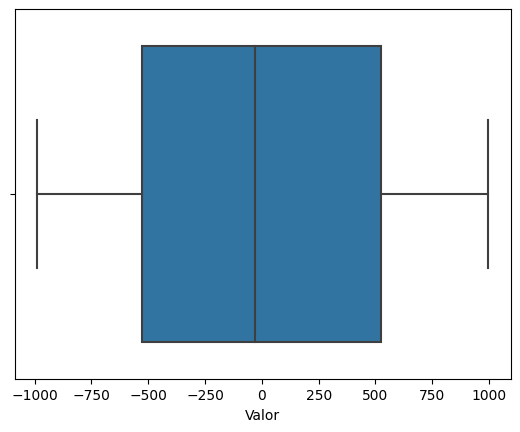

In [96]:
sns.boxplot(x=filtrado_2["Valor"]);

# Existem valores negativos entre  registros. Podemos assumir que sejam clientes com débitos não quitados até a data informada, por exemplo.

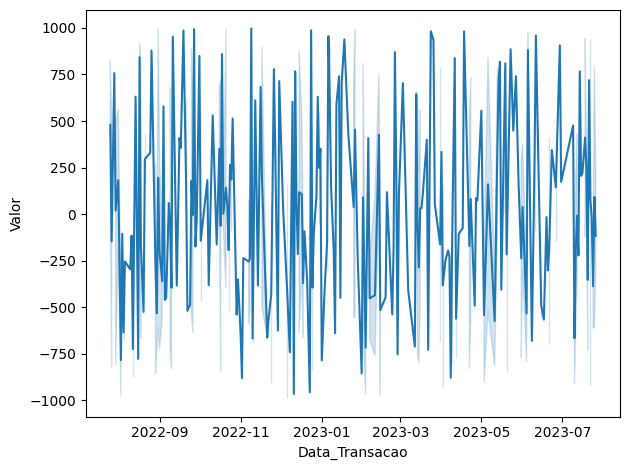

In [94]:
sns.lineplot(filtrado_2, y="Valor", x='Data_Transacao')
plt.tight_layout()

Além disso, extrapolando o objetivo inicial dessa análise, se quiséssemos olhar não somente para o cluster das anomalias, esse script também poderia ser aproveitado para explorar os demais clusters que foram identificados. Por exemplo, continuando no caso de uso contábil, os clusters poderiam ser melhor estudados e possibilitar a indicação de serviços mais aderentes a cada grupo de cliente, baseado nos seus gastos, frequência de transações e etc.